# End2End Neural Style Transfer

### Ref:  [Perceptual Losses for Real-Time Style Transfer and Super-Resolution]

By: Justin Johnson, Alexandre Alahi, Li Fei-Fei


In [26]:
import sys
sys.path.insert(0,'../')

import os

import time 
import matplotlib.pyplot as plt
import numpy as np

import torch
# For getting VGG model
import torchvision.models.vgg as vgg
#import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
#from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from e2e_neural_style_model.transformer_net import TransformerNet
from utils import (
    gram_matrix, recover_image, ImgDataset,tensor_normalizer, now_datetime
)
from e2e_neural_style_model.loss_network import LossNetwork

%matplotlib inline
#ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore")

In [27]:
# set seeds
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)

# configure device
if torch.cuda.is_available():
    
    torch.cuda.manual_seed(SEED)
    # arguments for image loaders
    kwargs = {'num_workers': 4, 'pin_memory': True}
    
    # set device id
    device = torch.device("cuda")
    torch.cuda.set_device(1)
else:
    
    kwargs = {}
    device = torch.device("cpu")

print('CUDA device -> ',torch.cuda.current_device())

#set default tensor type
torch.set_default_tensor_type('torch.FloatTensor')


CUDA device ->  1


In [28]:
title = 'end2end_'+now_datetime()

# directory settup
dir_dict = {}
dir_dict['train_set'] ='/mnt/data/ce7454_dataset/trainA/'
dir_dict['debug_log']='../debug_log/'+title+'/'
dir_dict['save_model'] = '../trained_models/'+title+'.pth'

# create debug_log dir
os.mkdir(dir_dict['debug_log'])

In [29]:
#with torch.no_grad():
loss_network = LossNetwork()
loss_network.to(device)

# set loss_net to test mode to disable dropout and batchNorm
loss_network = loss_network.eval()

#### Load training sets

In [30]:
train_dataset = ImgDataset(dir_dict['train_set'])

print('Number of training samples -> ',len(train_dataset))

created dataset with dir >>  /mnt/data/ce7454_dataset/trainA/
Number of training samples ->  20000


#### Load style image

In [31]:
style_img = Image.open("../style_images/anime_face.jpg").convert('RGB')

#with torch.no_grad():
style_img_tensor = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    tensor_normalizer()]
)(style_img).unsqueeze(0)


style_img_tensor = style_img_tensor.to(device)

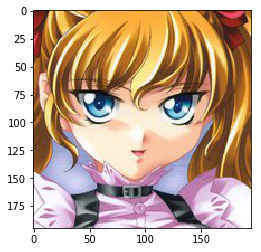

In [32]:
plt.imshow(style_img)
#plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

#### training setup

In [33]:
lr = 1e-3
#NOISE_P = 0.2
#NOISE_STD = 0.35
#NOISE_WEIGHT = 10 * 2

#### Precompute gram matrices of the style image:

In [34]:
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [35]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

optimizer = Adam(transformer.parameters(), lr) # LR * 0.1, LR *0.5

In [36]:
def save_debug_image(tensor_orig, tensor_transformed, filename): #tensor_with_noise, 
    
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    #noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    
    new_im = Image.new('RGB', (result.size[0] * 2+ 10, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    #new_im.paste(noise, (result.size[0] * 2 + 10,0))
    new_im.save(filename)

In [37]:
def train(train_dataset, n_epoch =10, batch_size=4, log_interval = 50, content_weight= 0.12,
            style_weight= np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3,  reg = 1e-6):
    
    transformer.train()
    
    # load images upon use
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
    
    batch_per_epoch = int(len(train_dataset) / batch_size)
    if(len(train_dataset) % batch_size ==0):
        batch_per_epoch = batch_per_epoch - 1
                
    
    # reset running loss
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.   
    #agg_stable_loss = 0.
     
    # to log loss
    iteration = 0
    
    for epoch in range(1, n_epoch+1):
        
        start_time = time.time()
        for i_batch, x in enumerate(train_loader):
            
            iteration = iteration +1
            
            # set the gradients to zero
            optimizer.zero_grad()
        
            # send the minibatch to GPU
            x = x.to(device) 
            
            # forward the input images to transformer
            y = transformer(x)  
            
            
            # forward the input images to loss-network
            with torch.no_grad():
                xc = x.detach()
                features_xc = loss_network(xc)
            
            # forward the transformed image to loss_network
            features_y = loss_network(y)
            
            # compute content loss detached from relu3_3
            with torch.no_grad():
                f_xc_c = features_xc[2].detach()

            content_loss = content_weight * mse_loss(features_y[2], f_xc_c)

            # Total Variation Regularization
            reg_loss = reg * (
                torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
                torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))
            
            #compute style loss
            style_loss = 0.
            for l, weight in enumerate(style_weight):
                gram_s = gram_style[l]
                gram_y = gram_matrix(features_y[l])
                style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
            #stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

            # compute total loss and backpropagate
            total_loss = content_loss + style_loss + reg_loss #+ stability_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss
            agg_style_loss += style_loss
            agg_reg_loss += reg_loss
            #agg_stable_loss += stability_loss

            if (i_batch % log_interval == 0 or i_batch == batch_per_epoch):
                mesg = "[epoch {}, iter {}] time: {:.2f} content: {:.2f}  style: {:.2f}  reg: {:.2f}  total: {:.6f}".format(
                            epoch, i_batch, (time.time()-start_time)/60,
                            agg_content_loss / iteration,
                            agg_style_loss / iteration,
                            agg_reg_loss /iteration,
                            #agg_stable_loss / iteration, stable: {:.2f}     + agg_stable_loss
                            (agg_content_loss + agg_style_loss + 
                             agg_reg_loss ) / iteration
                        )
                print(mesg)
                iteration = 0
                agg_content_loss = 0.
                agg_style_loss = 0.
                agg_reg_loss = 0.
               # agg_stable_loss = 0.
                
                # switch to test mode
                with torch.no_grad():
                    transformer.eval()
                    input_img = x[0,:,:,:].unsqueeze(0)
                    y = transformer(input_img )
                    save_debug_image(input_img, y.detach(),  dir_dict['debug_log']+"epoch_{}_iter_{}_.png".format(epoch,i_batch)) #y_noise.detach(),
                
                # switch back to training mode
                transformer.train()


In [38]:
# start training
train(train_dataset, n_epoch = 2,log_interval =500)

# save the trained model
torch.save(transformer.state_dict(), dir_dict['save_model'])

[epoch 1, iter 0] time: 0.01 content: 1.03  style: 18.30  reg: 0.13  total: 19.453697
[epoch 1, iter 500] time: 2.23 content: 2.34  style: 2.72  reg: 0.22  total: 5.283759
[epoch 1, iter 1000] time: 4.46 content: 2.16  style: 1.53  reg: 0.25  total: 3.932655
[epoch 1, iter 1500] time: 6.68 content: 2.06  style: 1.32  reg: 0.24  total: 3.614997
[epoch 1, iter 2000] time: 8.90 content: 2.00  style: 1.24  reg: 0.24  total: 3.475126
[epoch 1, iter 2500] time: 11.13 content: 1.97  style: 1.16  reg: 0.23  total: 3.361284
[epoch 1, iter 3000] time: 13.35 content: 1.92  style: 1.11  reg: 0.23  total: 3.262732
[epoch 1, iter 3500] time: 15.58 content: 1.90  style: 1.09  reg: 0.23  total: 3.217339
[epoch 1, iter 4000] time: 17.80 content: 1.87  style: 1.06  reg: 0.23  total: 3.159523
[epoch 1, iter 4500] time: 20.03 content: 1.86  style: 1.03  reg: 0.22  total: 3.117267
[epoch 1, iter 4999] time: 22.25 content: 1.84  style: 1.02  reg: 0.22  total: 3.079571
[epoch 2, iter 0] time: 0.01 content: 1